# Baseline Training and Prediction Results
This notebook will provide us with a baseline for comparing the four methods of training on datasets with limited data (data augmentation, transfer learning, one-shot learning, and zero-shot learning). For the baseline model, we train using the full dataset; wherease, for the other four methods we will train only on a small-subset of the dataset.  

In [1]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
# from common.torch_utils import train_model,get_device
# from torch_utils import (train_model, 
#                          mnist_dataloader, 
#                          dataset_preview)
from torch_utils import *

# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



## Data Preprocessing
We need to collect the MNIST data and create the dataloaders for PyTorch. To make a clean notebook, we have created a helper function to do most of the work (refer to `/src/common/torch_utils.py`). For training the base model, we will use a batch size of 32. 

Data will be located in '../../data'


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw




Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
Dataset sizes: {'train': 60000, 'val': 9900, 'pred': 100}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']




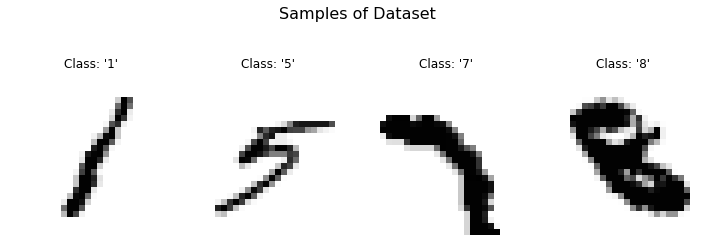

In [2]:
BATCH_SIZE = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,batch_size=BATCH_SIZE,pred_size=0.01)
dataloaders, dataset_sizes, class_names = tmp 
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders['val'])

## Train the Model on the Full Dataset
For the base model we will use a ResNet, specifically the ResNet-18. The MNIST dataset is relatively small (60k training images and 10k validation images) and has only 10 output classifiers, making a larger ResNet (e.g., ResNet-50) unnecessary. Before we can use the pretrained model, however, a couple of considerations are made. First, ResNet was pretrained with the ImageNet dataset which consists of 224x224 RGB (3-channel) images; however, the MNIST dataset consists of 28x28 Grayscale (1-channel) images. The first two dimensions (HxW) are not an issue for the ResNet-18 model (we may have to retrain vs. finetune), but the third dimension discrepency will cause an error for the PyTorch model. The solution to this issue, as stated in this [reference](https://discuss.pytorch.org/t/altering-resnet18-for-single-channel-images/29198/10), is to modify the first convolutional layer changing it from `torch.nn.Conv1d(3, 64, ...)` to `torch.nn.Conv1d(1, 64, ...)` as shown in the code below.  

Second, ImageNet conists of 1000 classifications for it's labeled dataset. The MNIST dataset, as mentioned earlier, has only 10 classifications (representing handwritten numbers 0 through 10). Again, PyTorch will give a dimension mismatch error if we try to use the MNIST dataset without modifying the network. To resolve the output mismatch, we modify the output fully-connected layer with this simple line of code: `model.fc = nn.Linear(model.fc.in_features, 10)`.   

With these two modifications to the ResNet-18 netowrk, we can initiate the training process. To once again keep this notebook clean and to encourage consistent code reuse, we have put the details of the trainning process in a helper function, `train_model()`. 

In [3]:
NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False

# Use Torchvision Resnet18 for base model since our 
# dataset is small and only has 10 classes
model_ResNet18 = models.resnet18(pretrained=pretrained)

# prepare the pre-trained model: 
#   Note the following considerations given our dataset for ResNet
#     -> MNIST data are 1-channel (grascale) of size and has 10 output classes
#     -> ResNet model expects 3-channel (RGB) images of size 224x224 as input 
#        and has 1000 output classes
#     == We must changet the last fully connected layer to match 10 classes
# keep features unchanged
num_features = model_ResNet18.fc.in_features

# change the output layer to match number of new classes
model_ResNet18.fc = nn.Linear(num_features, NUM_CLASSES)

# change the first conv layer for single channel images
model_ResNet18.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
# ref: https://discuss.pytorch.org/t/altering-resnet18-for-single-channel-images/29198/10

# move model to the GPU
cudnn.benchmark = True

# use helper function to train the model (outputs model and Pandas DF)
model_ResNet18, results_df_ResNet18,_ = train_model(device, model_ResNet18, 
                                                    dataloaders, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
     # <-- train_model should have created this dir
    model_name = 'ResNet18'
    results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
    results_df_ResNet18.to_csv(os.path.join(output_dir,results_file),
                      columns=results_df_ResNet18.columns)
    print(f'> Saved results to \'{results_file}\'.')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth




Epoch 0/99
----------
train Loss: 1.2366 Acc: 0.6781
val Loss: 0.2308 Acc: 0.9394

Epoch 1/99
----------
train Loss: 0.2099 Acc: 0.9365
val Loss: 0.1801 Acc: 0.9505

Epoch 2/99
----------
train Loss: 0.1429 Acc: 0.9564
val Loss: 0.1246 Acc: 0.9657

Epoch 3/99
----------
train Loss: 0.1092 Acc: 0.9675
val Loss: 0.0826 Acc: 0.9749

Epoch 4/99
----------
train Loss: 0.091 Acc: 0.9715
val Loss: 0.2156 Acc: 0.9582

Epoch 5/99
----------
train Loss: 0.0776 Acc: 0.9761
val Loss: 0.0854 Acc: 0.9781

Epoch 6/99
----------
train Loss: 0.0677 Acc: 0.979
val Loss: 0.051 Acc: 0.9842

Epoch 7/99
----------
train Loss: 0.0614 Acc: 0.9815
val Loss: 0.0466 Acc: 0.9852

Epoch 8/99
----------
train Loss: 0.0542 Acc: 0.9836
val Loss: 0.0538 Acc: 0.9837

Epoch 9/99
----------
train Loss: 0.049 Acc: 0.9845
val Loss: 0.0711 Acc: 0.9773

Epoch 10/99
----------
train Loss: 0.0443 Acc: 0.9862
val Loss: 0.0504 Acc: 0.9849

Epoch 11/99
----------
train Loss: 0.0415 Acc: 0.9868
val Loss: 0.0485 Acc: 0.984

Epoch

## Evaluate the Model from Full Dataset Training
During our data pre-processing (in the `mnist_dataloader()` function) we have intentionally split off 10% of the validation dataset that we can use for evaluating the model. First, notice that in 3 epochs we were able to achieve 97% accuracy using the ResNet-18 pretrained model (not bad!). Now, let's go ahead and use the `plot_classes_preds()` function from a somewhat unrealated PyTorch [tutorial](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) (referenece linked). The results of this function are below. 

tensor([5, 0, 4, 1, 3, 4, 1, 8, 1, 0, 8, 1, 5, 8, 8, 4, 8, 1, 1, 0, 4, 9, 7, 7,
        0, 5, 6, 0, 2, 6, 9, 9])


[]

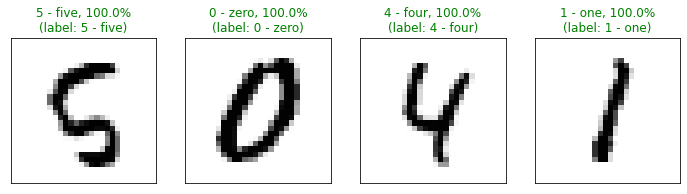

In [4]:
# Evaluate the model using the prediction set held-off
model_ResNet18.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet18,inputs,labels,class_names) 
plt.plot()

## Preprocess Limited Dataset

## Train the Model on the Limited Dataset

## Evaluate the Model from Limited Dataset Training

## Train other models as comparison points

In [18]:
# create ResNet50 Model
model_ResNet50 = models.resnet18(pretrained=pretrained)
num_features = model_ResNet50.fc.in_features
model_ResNet50.fc = nn.Linear(num_features, NUM_CLASSES)
model_ResNet50.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
cudnn.benchmark = True

# train ResNet50 models
model_ResNet50, results_df_ResNet50,_ = train_model(device, model_ResNet50, 
                                                    dataloaders, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
    model_name = 'ResNet50'
    results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
    results_df_ResNet50.to_csv(os.path.join(output_dir,results_file),
                      columns=results_df_ResNet50.columns)
    print(f'> Saved results to \'{results_file}\'.')


Epoch 0/99
----------
train Loss: 0.4159 Acc: 0.9076
val Loss: 0.0652 Acc: 0.9779

Epoch 1/99
----------
train Loss: 0.0837 Acc: 0.9751
val Loss: 0.0417 Acc: 0.9867

Epoch 2/99
----------
train Loss: 0.0582 Acc: 0.9828
val Loss: 0.0438 Acc: 0.9859

Epoch 3/99
----------
train Loss: 0.0449 Acc: 0.9866
val Loss: 0.0311 Acc: 0.9904

Epoch 4/99
----------
train Loss: 0.0383 Acc: 0.9879
val Loss: 0.0288 Acc: 0.9908

Epoch 5/99
----------
train Loss: 0.0316 Acc: 0.9902
val Loss: 0.0289 Acc: 0.9913

Epoch 6/99
----------
train Loss: 0.0271 Acc: 0.9917
val Loss: 0.0327 Acc: 0.989

Epoch 7/99
----------
train Loss: 0.023 Acc: 0.9932
val Loss: 0.0351 Acc: 0.9886

Epoch 8/99
----------
train Loss: 0.0199 Acc: 0.994
val Loss: 0.0276 Acc: 0.9919

Epoch 9/99
----------
train Loss: 0.0172 Acc: 0.9947
val Loss: 0.0345 Acc: 0.9913

Epoch 10/99
----------
train Loss: 0.0156 Acc: 0.9954
val Loss: 0.043 Acc: 0.9875

Epoch 11/99
----------
train Loss: 0.0157 Acc: 0.9948
val Loss: 0.0394 Acc: 0.9893

Epoch

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [43]:
# create VGG11 Model
model_VGG11 = models.vgg11(pretrained=pretrained)
num_features = model_VGG11.classifier[6].in_features
#model_VGG11.fc = nn.Linear(num_features, NUM_CLASSES)
model_VGG11.features[0] = torch.nn.Conv2d(1, 64, 3, 1, 1)
model_VGG11.features = torch.nn.Sequential(*[model_VGG11.features[ii] for ii in range(15)])
model_VGG11.classifier = torch.nn.Sequential(*[model_VGG11.classifier[jj] for jj in range(4)])
model_VGG11.classifier[-1] = torch.nn.Linear(num_features, NUM_CLASSES)
cudnn.benchmark = True

print(model_VGG11)

# train all models
model_VGG11, results_df_VGG11,_ = train_model(device, model_VGG11, 
                                              dataloaders, dataset_sizes, 
                                              num_epochs=NUM_EPOCHS)

# save the data for others to use
    model_name = 'VGG11'
    results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
    results_df_VGG11.to_csv(os.path.join(output_dir,results_file),
                      columns=results_df_VGG11.columns)
    print(f'> Saved results to \'{results_file}\'.')

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
   

In [ ]:
# create VGG16 Model
model_VGG16 = models.vgg16(pretrained=pretrained)
num_features = model_VGG16.classifier[6].in_features
model_VGG16.features[0] = torch.nn.Conv2d(1, 64, 3, 1, 1)
model_VGG16.features = torch.nn.Sequential(*[model_VGG16.features[ii] for ii in range(23)])
model_VGG16.classifier = torch.nn.Sequential(*[model_VGG16.classifier[jj] for jj in range(4)])
model_VGG16.classifier[-1] = torch.nn.Linear(num_features, NUM_CLASSES)
cudnn.benchmark = True

print(model_VGG16)

# train all models
model_VGG16, results_df_VGG16,_ = train_model(device, model_VGG16, 
                                              dataloaders, dataset_sizes, 
                                              num_epochs=NUM_EPOCHS)

# save the data for others to use
    model_name = 'VGG16'
    results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
    results_df_VGG16.to_csv(os.path.join(output_dir,results_file),
                      columns=results_df_VGG16.columns)
    print(f'> Saved results to \'{results_file}\'.')

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
# create DenseNet161 Model
model_DenseNet161 = models.densenet161(pretrained=pretrained)
#num_features = model_DenseNet161.classifier[6].in_features
#model_DenseNet161.fc = nn.Linear(num_features, NUM_CLASSES)
model_DenseNet161.features.conv0 = torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_DenseNet161.features.pool0 = torch.nn.Identity()
model_DenseNet161.classifier = torch.nn.Linear(2208, NUM_CLASSES, bias=True)
cudnn.benchmark = True

print(model_DenseNet161)

# train all models
model_DenseNet161, results_df_DenseNet161,_ = train_model(device, model_DenseNet161, 
                                              dataloaders, dataset_sizes, 
                                              num_epochs=NUM_EPOCHS)

# save the data for others to use
    model_name = 'DenseNet161'
    results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
    results_df_DenseNet161.to_csv(os.path.join(output_dir,results_file),
                      columns=results_df_DenseNet161.columns)
    print(f'> Saved results to \'{results_file}\'.')

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): Identity()
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(144, 192, kernel

KeyboardInterrupt: 

In [ ]:
# Evaluate the model using the prediction set held-off
model_ResNet50.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet50,inputs,labels,class_names) 
plt.plot()

In [ ]:
# Evaluate the model using the prediction set held-off
model_VGG11.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_VGG11,inputs,labels,class_names) 
plt.plot()

In [ ]:
# Evaluate the model using the prediction set held-off
model_VGG16.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_VGG16,inputs,labels,class_names) 
plt.plot()

In [ ]:
# Evaluate the model using the prediction set held-off
model_DenseNet161.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_DenseNet161,inputs,labels,class_names) 
plt.plot()

## Conclusion
In closing, this notebook was intended to provide us with a baseline, a "zero" if you will. I think it is pretty clear from the work in this notebook that the ResNet-18 is a reasonable target model to finetune as a classifier for the MNIST dataset. Now, let's see how other methods can compare when dealing with a limited dataset for training.

## References:
[1] https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html